# Ablation study

**Objetivo:** Comparar los resultados obtenidos en los distintos pasos vs un enfoque baseline


# Dependencies

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from dowhy import CausalModel
from castle.common import GraphDAG
from castle.algorithms import PC
from causallearn.search.ConstraintBased.FCI import fci
from sklearn.base import clone
from catboost import CatBoostClassifier, CatBoostRegressor

from config import TREATMENT, OUTCOME
from utils.potential_outcomes import (
    get_metrics,
    individual_dose_response_curve,
    average_dose_response_curve,
)
from utils.graphs import (
    get_nx_graph_FCI,
    create_prior,
    get_edges_list_from_gcastlegraph,
    analyze_dag_issues,
    make_dag,
    get_outcome_only_causes,
)


from utils.preprocessing import create_stratification_split_col
from utils.linear_regression import build_sm_regression_formula
from modules.iptw import ContinuousIPTW
from utils.error_estimates import get_ci_estimation_results

import warnings
warnings.filterwarnings("ignore")

2025-01-24 15:14:22,526 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2025-01-24 15:14:22,654 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


# Environment variables

In [2]:
CONTROLS_PATH = "data/controls.txt"
OUTCOME_CAUSES_PATH = "data/outcome_causes.txt"
DATA_GENERATOR_PATH = 'data/data_generator.pkl'

In [3]:
ground_truth_confounders = [
    'years_since_default',
    'default_debt_amount',
    'n_loans',
    'debt_cirbe',
    'n_cards'
]
ground_truth_outcome_causes = [
    'years_history',
    'n_accounts',
    'months_since_first_payment'
]

In [4]:
step = 1
bin_edges = np.arange(0, 100+step, step)

In [5]:
colors = {
    "logistic_reg": "orange",
    "s_learner": "darkblue",
    "iptw": "lightblue",
}

In [6]:
est_methods = ["logistic_reg"]
n_iterations = 100

# Utils

In [7]:
def print_results(results_dict, est_methods):
    for est_method in est_methods:
        results_method = results_dict[est_method]
        mean_error = results_method["estimation-error"]["average"].mean()
        var_error = results_method["estimation-error"]["average"].var()
        error_lower_bound = results_method["estimation-error"]["lower_bound"].mean()
        error_upper_bound = results_method["estimation-error"]["upper_bound"].mean()
        print(f"{est_method}:")
        print(f"Mean RMSE: {mean_error:.4f}, [{error_lower_bound:.4}-{error_upper_bound:.4}]")
        print(f"Mean Variance RMSE: {var_error:.4f}")


# Data

In [8]:
with open(CONTROLS_PATH) as f:
    controls = f.read().split("\n")
controls = [c for c in controls if c != ""]
controls


['n_loans',
 'n_cards',
 'loss_given_default',
 'debt_cirbe',
 'n_refin',
 'default_debt_amount',
 'years_since_default']

In [9]:
with open(OUTCOME_CAUSES_PATH) as f:
    outcome_causes = f.read().split("\n")
outcome_causes = [c for c in outcome_causes if c != ""]
outcome_causes

['n_accounts', 'years_history']

In [10]:
df_original = pd.read_parquet("data/synthetic_data.parquet")
df = df_original[controls + outcome_causes + [TREATMENT, OUTCOME]]
train_propagated = pd.read_parquet("data/synthetic_train_data_propagated.parquet")

In [11]:
with open(DATA_GENERATOR_PATH, 'rb') as file:
    generator = pickle.load(file)

# Split

In [12]:
strat_feature = create_stratification_split_col(df, TREATMENT, OUTCOME)
train, test = train_test_split(
    df_original, test_size=0.2, random_state=42, 
    stratify=strat_feature,
)

X_train_propagated, y_train_propagated = (
    train_propagated[controls + outcome_causes + [TREATMENT]],
    train_propagated[[OUTCOME]],
)

X_train, y_train = (
    train.drop(columns=[OUTCOME]).copy(),
    train[[OUTCOME]],
)
X_test, y_test = (
    test[X_train.columns],
    test[[OUTCOME]],
)
test_original = df_original.loc[test.index, :]
print(X_train_propagated.shape, X_train.shape, X_test.shape)

(14117, 10) (12000, 411) (3000, 411)


In [13]:
# Scale
features_scale = list(X_train.columns)
train_scaled = train.copy()
test_scaled = test.copy()

scaler = StandardScaler()
train_scaled[features_scale] = pd.DataFrame(
    scaler.fit_transform(train[features_scale]), columns=features_scale, index=train.index
)
test_scaled[features_scale] = pd.DataFrame(
    scaler.transform(test[features_scale]), columns=features_scale, index=test.index
)

# Identification without dimensionality reduction

In [14]:
features_graph = list(X_train.columns) + [OUTCOME]

## PC

In [15]:
# gcastle
priori = create_prior(
    train[features_graph],
    "gcastle",
    TREATMENT,
    OUTCOME,
    "pc",
    force_treatmemnt_output=True,
)

pc_gcstle = PC(variant="original", alpha=0.01, ci_test="fisherz", priori_knowledge=priori)
pc_gcstle.learn(train_scaled[features_graph])

print(pc_gcstle.causal_matrix)

# plot predict_dag and true_dag
GraphDAG(pc_gcstle.causal_matrix)

# add edges from a list of tuples
edges_list = get_edges_list_from_gcastlegraph(pc_gcstle, features_graph)

# create a directed graph
pc_G = nx.DiGraph()
pc_G.add_edges_from(edges_list)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    pc_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(pc_G),
)
plt.show()

KeyboardInterrupt: 

In [16]:
# First analyze the issues
problematic_edges = analyze_dag_issues(pc_G)

# If you want to automatically fix it
if len(problematic_edges) > 0:
    pc_G = make_dag(pc_G)

Found cycles:
redundantfeature45_debt_cirbe -> debt_cirbe -> redundantfeature45_debt_cirbe
redundantfeature50_debt_cirbe -> debt_cirbe -> redundantfeature50_debt_cirbe
debt_cirbe -> redundantfeature77_debt_cirbe -> debt_cirbe
debt_cirbe -> redundantfeature81_debt_cirbe -> debt_cirbe
debt_cirbe -> redundantfeature100_debt_cirbe -> debt_cirbe
months_since_first_payment -> redundantfeature72_months_since_first_payment -> months_since_first_payment
redundantfeature66_n_refin -> n_refin -> redundantfeature66_n_refin
n_refin -> redundantfeature20_n_refin -> n_refin
redundantfeature14_default_debt_amount -> default_debt_amount -> redundantfeature14_default_debt_amount
redundantfeature16_default_debt_amount -> default_debt_amount -> redundantfeature16_default_debt_amount
default_debt_amount -> redundantfeature78_default_debt_amount -> default_debt_amount
redundantfeature62_loss_given_default -> loss_given_default -> redundantfeature62_loss_given_default
redundantfeature53_loss_given_default ->

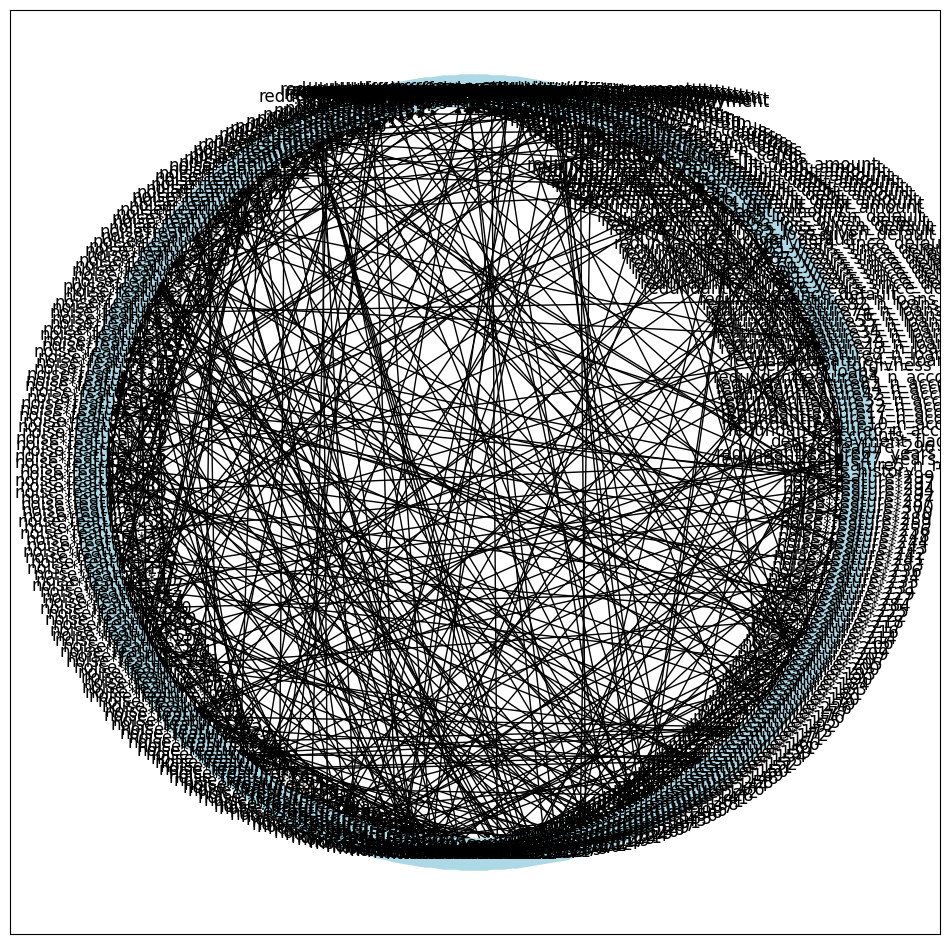

In [17]:
edges_list = [e for e in pc_G.edges]
if (TREATMENT, OUTCOME) not in edges_list:
    pc_G.add_edge(TREATMENT, OUTCOME)
    
# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    pc_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(pc_G),
)
plt.show()

In [18]:
model_pc = CausalModel(
    data=train[features_graph],
    treatment=TREATMENT,
    outcome=OUTCOME,
    graph="\n".join(nx.generate_gml(pc_G)),
)

# Identify the effect
identified_estimand_pc = model_pc.identify_effect()

print(identified_estimand_pc)

2025-01-20 14:38:50,380 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:505] - INFO: Model to find the causal effect of treatment ['perc_debt_forgivness'] on outcome ['debt_repayment_flag']
2025-01-20 14:38:50,381 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:613] - WARNING: There are an additional 9 variables in the dataset that are not in the graph. Variable names are: '['noise*feature*201', 'noise*feature*203', 'noise*feature*221', 'noise*feature*230', 'noise*feature*254', 'noise*feature*39', 'noise*feature*55', 'noise*feature*74', 'noise*feature*87']'
2025-01-20 14:54:36,735 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_identifier\auto_identifier.py[line:763] - INFO: Causal effect can be identified.
2025-01-20 14:54:36,741 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_identifier\auto_identifier.py[line:260] - INFO: Instrum

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
───────────────────────(E[debt_repayment_flag|loss_given_default,default_debt_
d[perc_debt_forgivness]                                                       

                
amount,n_loans])
                
Estimand assumption 1, Unconfoundedness: If U→{perc_debt_forgivness} and U→debt_repayment_flag then P(debt_repayment_flag|perc_debt_forgivness,loss_given_default,default_debt_amount,n_loans,U) = P(debt_repayment_flag|perc_debt_forgivness,loss_given_default,default_debt_amount,n_loans)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                            
 ⎢                         d                                                ⎛ 
E⎢────────────────────────────────────────────────────(debt_repayment_flag)⋅⎜─
 ⎣d[debt_cirbe  years_

In [19]:
estimate = model_pc.estimate_effect(
    identified_estimand_pc,
    method_name="backdoor.linear_regression",
    test_significance=True,
)
print(estimate)

2025-01-20 14:54:37,041 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:329] - INFO: linear_regression
2025-01-20 14:54:37,044 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\linear_regression_estimator.py[line:70] - INFO: INFO: Using Linear Regression Estimator
2025-01-20 14:54:37,049 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\regression_estimator.py[line:147] - INFO: b: debt_repayment_flag~perc_debt_forgivness+loss_given_default+default_debt_amount+n_loans+perc_debt_forgivness*noise*feature*77+perc_debt_forgivness*redundantfeature72_months_since_first_payment+perc_debt_forgivness*months_since_first_payment+perc_debt_forgivness*redundantfeature74_years_history+perc_debt_forgivness*noise*feature*9+perc_debt_forgivness*redundantfeature11_n_accounts+perc_debt_forgivness*noise*feature*99+perc_debt_forgivness*n_accounts+perc_debt_forgivness*redundantfeatu

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
───────────────────────(E[debt_repayment_flag|loss_given_default,default_debt_
d[perc_debt_forgivness]                                                       

                
amount,n_loans])
                
Estimand assumption 1, Unconfoundedness: If U→{perc_debt_forgivness} and U→debt_repayment_flag then P(debt_repayment_flag|perc_debt_forgivness,loss_given_default,default_debt_amount,n_loans,U) = P(debt_repayment_flag|perc_debt_forgivness,loss_given_default,default_debt_amount,n_loans)

## Realized estimand
b: debt_repayment_flag~perc_debt_forgivness+loss_given_default+default_debt_amount+n_loans+perc_debt_forgivness*noise*feature*77+perc_debt_forgivness*redundantfeature72_months_since_first_payment+perc_debt_forgivness*months_since_first_payment+pe

In [22]:
backdoor_variables_pc = identified_estimand_pc.get_backdoor_variables()
print("Backdoor adjustment set FCI:", backdoor_variables_pc)

Backdoor adjustment set FCI: ['loss_given_default', 'default_debt_amount', 'n_loans']


In [23]:
outcome_causes_pc = get_outcome_only_causes(pc_G, OUTCOME, TREATMENT)

Features that cause ONLY the outcome: ['years_history', 'n_accounts', 'months_since_first_payment', 'noise*feature*52', 'noise*feature*99']


## FCI

  0%|          | 0/412 [00:00<?, ?it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X412
Orienting edge (Knowledge): X2 --> X412
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X3 --> X412
Orienting edge (Knowledge): X4 --> X11
Orienting edge (Knowledge): X5 --> X11
Orienting edge (Knowledge): X5 --> X412
Orienting edge (Knowledge): X6 --> X11
Orienting edge (Knowledge): X6 --> X412
Orienting edge (Knowledge): X7 --> X11
Orienting edge (Knowledge): X8 --> X11
Orienting edge (Knowledge): X9 --> X412
Orienting edge (Knowledge): X10 --> X11
Orienting edge (Knowledge): X210 --> X412
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X412
Orienting edge (Knowledge): X2 --> X412
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X3 --> X412
Orienting edge (Knowledge): X4 --> X11
Orienting edge (Knowledge): X5 --> X11
Orienting edge (Knowledge): X5 --> X412
Orienting edge (Knowledge): X6 --> X11
Orienting edge (Knowledge): X6 --> X412
Orienting ed

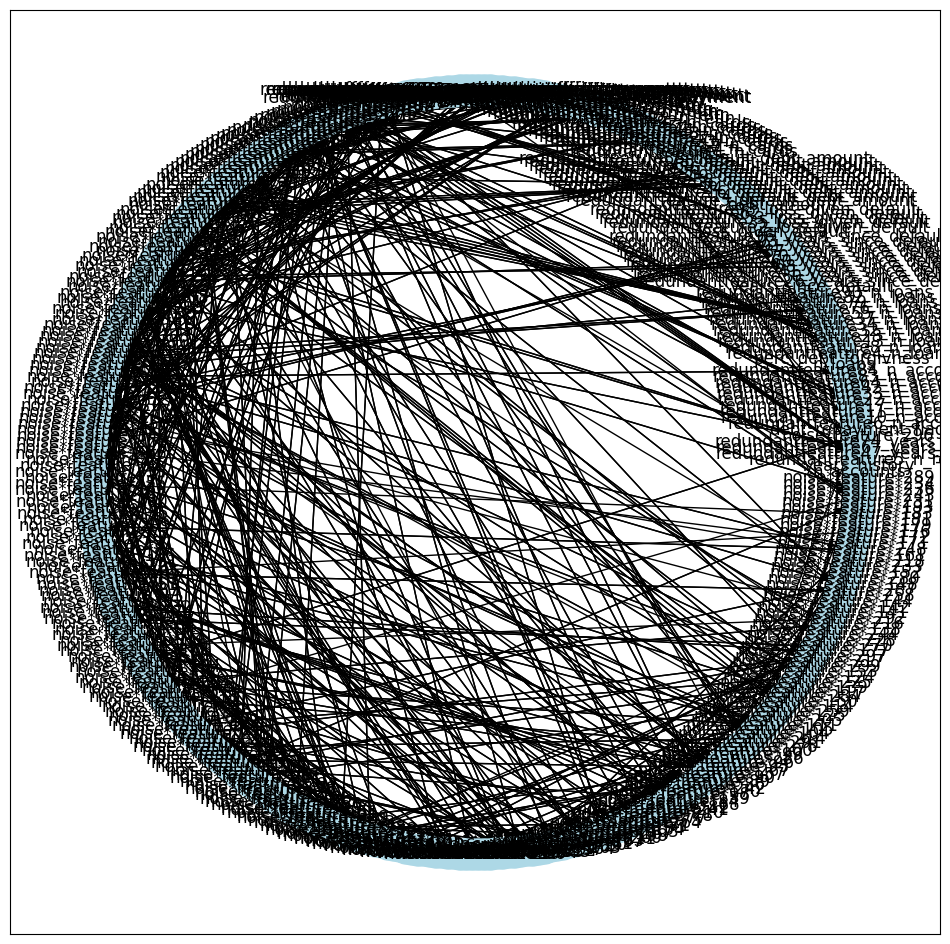

In [30]:
priori = create_prior(
    train_scaled[features_graph],
    "causal-learn",
    TREATMENT,
    OUTCOME,
    force_treatmemnt_output=True,
)

# or customized parameters
graph_fci, edges = fci(
    dataset=train_scaled[features_graph].to_numpy(),
    independence_test_method="fisherz",  # kci
    background_knowledge=priori,
    alpha=0.01,
)

fci_G = get_nx_graph_FCI(graph_fci.graph, features_graph)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    fci_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(fci_G),
)
plt.show()

In [ ]:
# First analyze the issues
problematic_edges = analyze_dag_issues(fci_G)

# If you want to automatically fix it
if len(problematic_edges) > 0:
    fci_G = make_dag(fci_G)

In [1]:
# force connection
edges_list = [e for e in fci_G.edges]
if (TREATMENT, OUTCOME) not in edges_list:
    fci_G.add_edge(TREATMENT, OUTCOME)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    fci_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(fci_G),
)
plt.show()

NameError: name 'fci_G' is not defined

In [27]:
model_fci = CausalModel(
    data=train[features_graph],
    treatment=TREATMENT,
    outcome=OUTCOME,
    graph="\n".join(nx.generate_gml(fci_G)),
)

# Identify the effect
identified_estimand_fci = model_fci.identify_effect()

print(identified_estimand_fci)

2025-01-19 19:38:08,930 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:505] - INFO: Model to find the causal effect of treatment ['perc_debt_forgivness'] on outcome ['debt_repayment_flag']
2025-01-19 19:38:08,930 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:613] - WARNING: There are an additional 33 variables in the dataset that are not in the graph. Variable names are: '['noise*feature*1', 'noise*feature*10', 'noise*feature*14', 'noise*feature*17', 'noise*feature*19', 'noise*feature*22', 'noise*feature*26', 'noise*feature*30', 'noise*feature*33', 'noise*feature*39', 'noise*feature*41', 'noise*feature*42', 'noise*feature*43', 'noise*feature*5', 'noise*feature*50', 'noise*feature*57', 'noise*feature*58', 'noise*feature*62', 'noise*feature*64', 'noise*feature*69', 'noise*feature*72', 'noise*feature*75', 'noise*feature*76', 'noise*feature*78', 'noise*feature*83', 'noise*feature*85', 'noise*feat

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
───────────────────────(E[debt_repayment_flag|redundantfeature13_n_loans,n_ref
d[perc_debt_forgivness]                                                       

                                                                              
in,n_accounts,years_history,years_since_default,redundantfeature2_loss_given_d
                                                                              

                                                                              
efault,default_debt_amount,noise*feature*24,noise*feature*12,noise*feature*52,
                                                                              

                                                                              
redundantfeature10_n_accounts,redundantfeature17_n_accounts,redundantfeature18
                   

In [28]:
estimate = model_fci.estimate_effect(
    identified_estimand_fci,
    method_name="backdoor.linear_regression",
    test_significance=True,
)
print(estimate)

2025-01-19 19:39:12,806 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:329] - INFO: linear_regression
2025-01-19 19:39:12,809 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\linear_regression_estimator.py[line:70] - INFO: INFO: Using Linear Regression Estimator
2025-01-19 19:39:12,810 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\regression_estimator.py[line:147] - INFO: b: debt_repayment_flag~perc_debt_forgivness+redundantfeature13_n_loans+n_refin+n_accounts+years_history+years_since_default+redundantfeature2_loss_given_default+default_debt_amount+noise*feature*24+noise*feature*12+noise*feature*52+redundantfeature10_n_accounts+redundantfeature17_n_accounts+redundantfeature18_n_refin+redundantfeature6_n_accounts+noise*feature*54+months_since_first_payment+noise*feature*98+redundantfeature11_n_accounts+noise*feature*23+redundantfeature20_n_refin+loss_giv

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
───────────────────────(E[debt_repayment_flag|redundantfeature13_n_loans,n_ref
d[perc_debt_forgivness]                                                       

                                                                              
in,n_accounts,years_history,years_since_default,redundantfeature2_loss_given_d
                                                                              

                                                                              
efault,default_debt_amount,noise*feature*24,noise*feature*12,noise*feature*52,
                                                                              

                                                                              
redundantfeature10_n_accounts,redundantfeature17_n

In [29]:
backdoor_variables_fci = identified_estimand_fci.get_backdoor_variables()
print("Backdoor adjustment set FCI:", backdoor_variables_fci)

Backdoor adjustment set FCI: ['redundantfeature13_n_loans', 'n_refin', 'n_accounts', 'years_history', 'years_since_default', 'redundantfeature2_loss_given_default', 'default_debt_amount', 'noise*feature*24', 'noise*feature*12', 'noise*feature*52', 'redundantfeature10_n_accounts', 'redundantfeature17_n_accounts', 'redundantfeature18_n_refin', 'redundantfeature6_n_accounts', 'noise*feature*54', 'months_since_first_payment', 'noise*feature*98', 'redundantfeature11_n_accounts', 'noise*feature*23', 'redundantfeature20_n_refin', 'loss_given_default', 'redundantfeature4_n_loans', 'redundantfeature7_n_cards', 'redundantfeature8_n_loans', 'n_loans', 'noise*feature*56', 'noise*feature*71', 'noise*feature*13', 'noise*feature*84', 'redundantfeature16_default_debt_amount', 'redundantfeature9_months_since_first_payment', 'redundantfeature5_n_refin', 'redundantfeature15_n_refin', 'redundantfeature19_n_cards', 'n_cards', 'noise*feature*73', 'noise*feature*11', 'redundantfeature1_n_cards', 'redundantfe

In [30]:
outcome_causes_fci = get_outcome_only_causes(fci_G, OUTCOME, TREATMENT)

Features that cause ONLY the outcome: ['n_accounts', 'years_history', 'noise*feature*56']


## Accuracy

In [32]:
backdoor_variables = list(set(backdoor_variables_pc) & set(backdoor_variables_fci))
len(backdoor_variables)

In [39]:
accurate_controls = [c for c in backdoor_variables if c in ground_truth_confounders]
failed_controls = [c for c in backdoor_variables if c not in ground_truth_confounders]
remaining_accurate = [c for c in train_scaled.columns if c not in [TREATMENT]+accurate_controls+failed_controls]
print(len(accurate_controls), len(failed_controls), len(remaining_accurate))

5 29 97


In [40]:
accurate_controls_pipe = [c for c in controls if c in ground_truth_confounders]
failed_controls_pipe = [c for c in controls if c not in ground_truth_confounders]
remaining_accurate_pipe = [c for c in train_scaled.columns if c not in [TREATMENT]+accurate_controls_pipe+failed_controls_pipe]
print(len(accurate_controls_pipe), len(failed_controls_pipe), len(remaining_accurate_pipe))

4 2 125


# Estimation without Dimensionality Reduction + Identification

In [14]:
monotone_constraints_list = []

for f in list(X_train.columns):
    if f != TREATMENT:
        monotone_constraints_list.append(0)
    else:
        monotone_constraints_list.append(1)

In [15]:
results_baseline = {}
adjustment_set_baseline = [c for c in train.columns if c not in [TREATMENT, OUTCOME]]
for est_method in est_methods:
    print(est_method)
    results_method = get_ci_estimation_results(
        estimation_method=est_method,
        train_df=train.copy(),
        n_iterations=n_iterations,
        intervention_df=test_original.copy(),
        intervention_values=bin_edges,
        adjustment_set=adjustment_set_baseline,
        outcome_causes=[],
        generator=generator,
        confidence_level=0.95,
        monotone_constrains=monotone_constraints_list,
    )
    results_baseline[est_method] = results_method

print_results(results_baseline, est_methods)

logistic_reg
[[0.342 0.344 0.347 ... 0.626 0.628 0.631]
 [0.315 0.318 0.321 ... 0.63  0.633 0.636]
 [0.34  0.343 0.345 ... 0.623 0.626 0.628]
 ...
 [0.336 0.339 0.341 ... 0.618 0.621 0.624]
 [0.319 0.323 0.326 ... 0.652 0.655 0.658]
 [0.353 0.356 0.359 ... 0.617 0.62  0.622]]
[[0.417 0.308 0.291 ... 0.388 0.41  0.441]
 [0.391 0.282 0.267 ... 0.383 0.406 0.437]
 [0.415 0.305 0.288 ... 0.391 0.414 0.445]
 ...
 [0.408 0.3   0.284 ... 0.392 0.415 0.446]
 [0.395 0.285 0.269 ... 0.364 0.387 0.418]
 [0.425 0.318 0.301 ... 0.395 0.417 0.449]]
logistic_reg:
Mean RMSE: 0.2316, [0.2157-0.2462]
Mean Variance RMSE: 0.0032


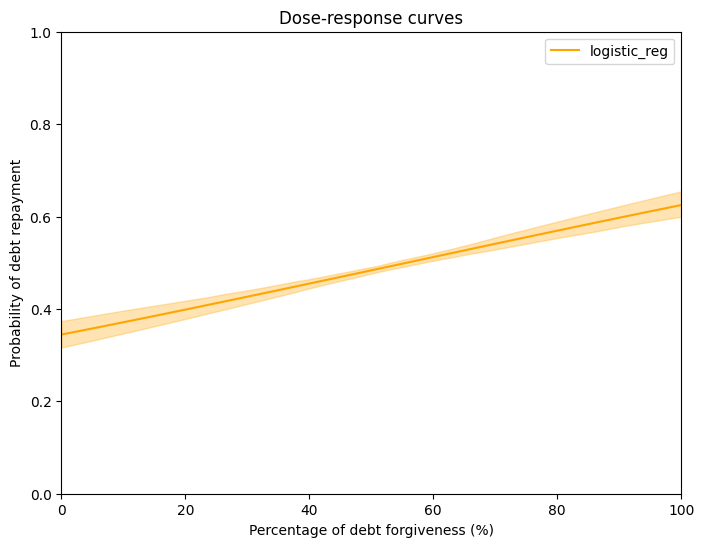

In [16]:
plt.figure(figsize=(8, 6))
for method, results_method in results_baseline.items():
    plt.plot(
        bin_edges,
        results_method["dose-response"]["average"],
        label=method,
        color=colors[method],
    )
    plt.fill_between(
        bin_edges,
        results_method["dose-response"]["lower_bound"],
        results_method["dose-response"]["upper_bound"],
        alpha=0.3,
        color=colors[method],
    )

plt.xlabel("Percentage of debt forgiveness (%)")
plt.ylabel("Probability of debt repayment")
plt.title("Dose-response curves")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

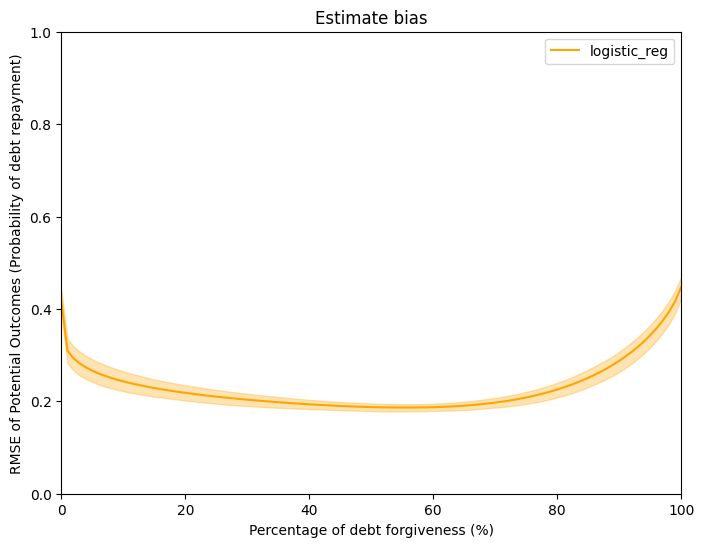

In [17]:
plt.figure(figsize=(8, 6))
for method, results_method in results_baseline.items():
    plt.plot(
        bin_edges,
        results_method["estimation-error"]["average"],
        label=method,
        color=colors[method],
    )
    plt.fill_between(
        bin_edges,
        results_method["estimation-error"]["lower_bound"],
        results_method["estimation-error"]["upper_bound"],
        alpha=0.3,
        color=colors[method],
    )

plt.xlabel("Percentage of debt forgiveness (%)")
plt.ylabel("RMSE of Potential Outcomes (Probability of debt repayment)")
plt.title("Estimate bias")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

# Estimation with confounders and without data-augmentation

In [18]:
monotone_constraints_list = []

for f in controls + outcome_causes+[TREATMENT]:
    if f != TREATMENT:
        monotone_constraints_list.append(0)
    else:
        monotone_constraints_list.append(1)

In [19]:
results_adjustment_set = {}
for est_method in est_methods:
    print(est_method)
    results_method = get_ci_estimation_results(
        estimation_method=est_method,
        train_df=train.copy(),
        n_iterations=n_iterations,
        intervention_df=test_original.copy(),
        intervention_values=bin_edges,
        adjustment_set=controls+outcome_causes,
        outcome_causes=outcome_causes,
        generator=generator,
        confidence_level=0.95,
        monotone_constrains=monotone_constraints_list,
    )
    # print(results_method)
    results_adjustment_set[est_method] = results_method
print_results(results_adjustment_set, est_methods)

logistic_reg
[[0.354 0.356 0.359 ... 0.612 0.615 0.617]
 [0.349 0.351 0.354 ... 0.622 0.624 0.627]
 [0.358 0.361 0.363 ... 0.612 0.615 0.617]
 ...
 [0.357 0.36  0.362 ... 0.614 0.616 0.619]
 [0.338 0.341 0.344 ... 0.629 0.631 0.634]
 [0.325 0.328 0.331 ... 0.635 0.638 0.641]]
[[0.408 0.298 0.28  ... 0.38  0.404 0.436]
 [0.407 0.292 0.274 ... 0.377 0.402 0.434]
 [0.41  0.3   0.282 ... 0.381 0.405 0.437]
 ...
 [0.412 0.3   0.282 ... 0.381 0.405 0.438]
 [0.396 0.283 0.265 ... 0.37  0.394 0.426]
 [0.379 0.267 0.25  ... 0.364 0.388 0.42 ]]
logistic_reg:
Mean RMSE: 0.2003, [0.1802-0.2201]
Mean Variance RMSE: 0.0040


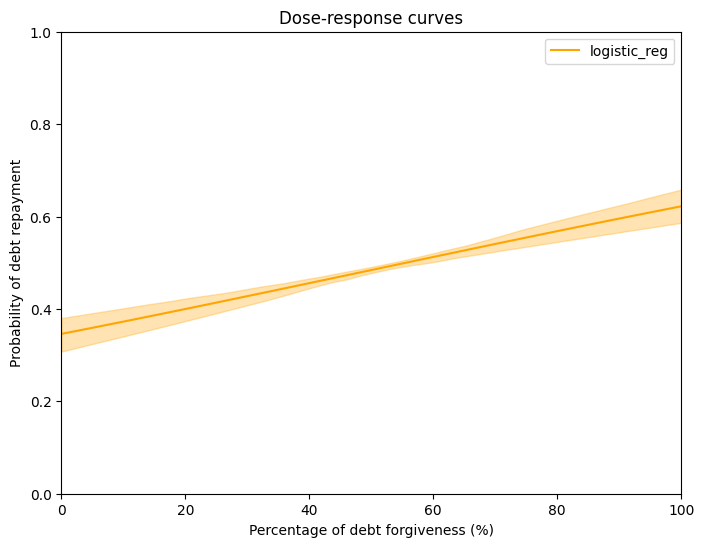

In [20]:
plt.figure(figsize=(8, 6))
for method, results_method in results_adjustment_set.items():
    plt.plot(
        bin_edges,
        results_method["dose-response"]["average"],
        label=method,
        color=colors[method],
    )
    plt.fill_between(
        bin_edges,
        results_method["dose-response"]["lower_bound"],
        results_method["dose-response"]["upper_bound"],
        alpha=0.3,
        color=colors[method],
    )

plt.xlabel("Percentage of debt forgiveness (%)")
plt.ylabel("Probability of debt repayment")
plt.title("Dose-response curves")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

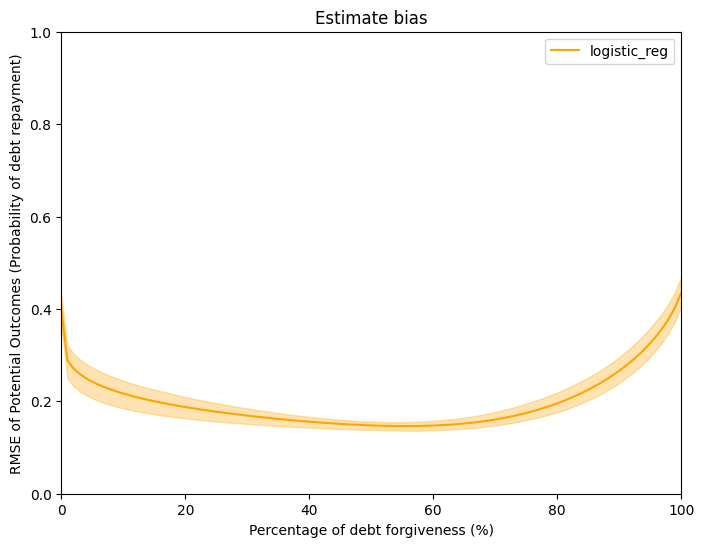

In [21]:
plt.figure(figsize=(8, 6))
for method, results_method in results_adjustment_set.items():
    plt.plot(
        bin_edges,
        results_method["estimation-error"]["average"],
        label=method,
        color=colors[method],
    )
    plt.fill_between(
        bin_edges,
        results_method["estimation-error"]["lower_bound"],
        results_method["estimation-error"]["upper_bound"],
        alpha=0.3,
        color=colors[method],
    )

plt.xlabel("Percentage of debt forgiveness (%)")
plt.ylabel("RMSE of Potential Outcomes (Probability of debt repayment)")
plt.title("Estimate bias")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

# Proposed Estimation

In [22]:
monotone_constraints_list = []
adjustment_set = controls + outcome_causes

for f in adjustment_set+[TREATMENT]:
    if f != TREATMENT:
        monotone_constraints_list.append(0)
    else:
        monotone_constraints_list.append(1)

In [23]:
results_pipeline = {}
for est_method in est_methods:
    print(est_method)
    results_method = get_ci_estimation_results(
        estimation_method=est_method,
        train_df=train_propagated.copy(),
        n_iterations=n_iterations,
        intervention_df=test_original.copy(),
        intervention_values=bin_edges,
        adjustment_set=adjustment_set,
        outcome_causes=outcome_causes,
        generator=generator,
        confidence_level=0.95,
        monotone_constrains=monotone_constraints_list,
    )
    results_pipeline[est_method] = results_method
print_results(results_pipeline, est_methods)

logistic_reg
[[0.137 0.141 0.146 ... 0.812 0.817 0.822]
 [0.133 0.137 0.142 ... 0.817 0.822 0.827]
 [0.134 0.138 0.143 ... 0.818 0.823 0.827]
 ...
 [0.14  0.145 0.15  ... 0.81  0.815 0.82 ]
 [0.139 0.144 0.148 ... 0.816 0.821 0.826]
 [0.14  0.145 0.149 ... 0.819 0.824 0.829]]
[[0.201 0.089 0.085 ... 0.204 0.229 0.267]
 [0.197 0.085 0.082 ... 0.2   0.226 0.264]
 [0.201 0.087 0.083 ... 0.204 0.23  0.268]
 ...
 [0.205 0.091 0.086 ... 0.208 0.234 0.272]
 [0.207 0.09  0.085 ... 0.203 0.229 0.267]
 [0.209 0.091 0.085 ... 0.201 0.227 0.266]]
logistic_reg:
Mean RMSE: 0.1123, [0.1091-0.1153]
Mean Variance RMSE: 0.0007


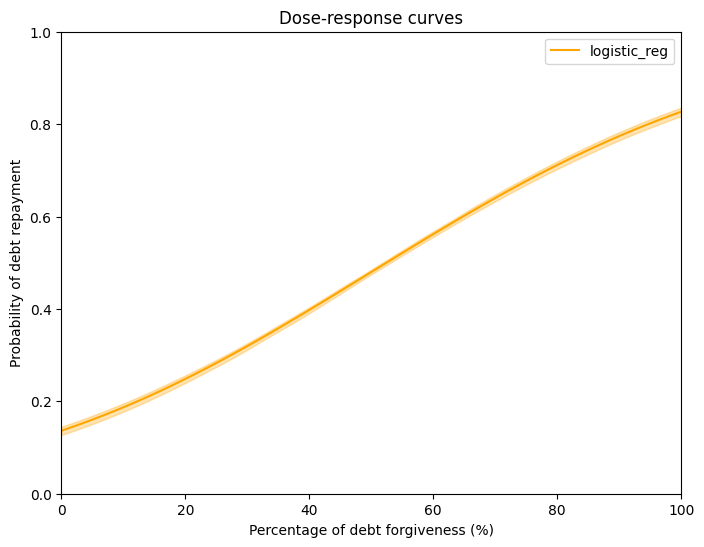

In [24]:
plt.figure(figsize=(8, 6))
for method, results_method in results_pipeline.items():
    plt.plot(
        bin_edges,
        results_method["dose-response"]["average"],
        label=method,
        color=colors[method],
    )
    plt.fill_between(
        bin_edges,
        results_method["dose-response"]["lower_bound"],
        results_method["dose-response"]["upper_bound"],
        alpha=0.3,
        color=colors[method],
    )

plt.xlabel("Percentage of debt forgiveness (%)")
plt.ylabel("Probability of debt repayment")
plt.title("Dose-response curves")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

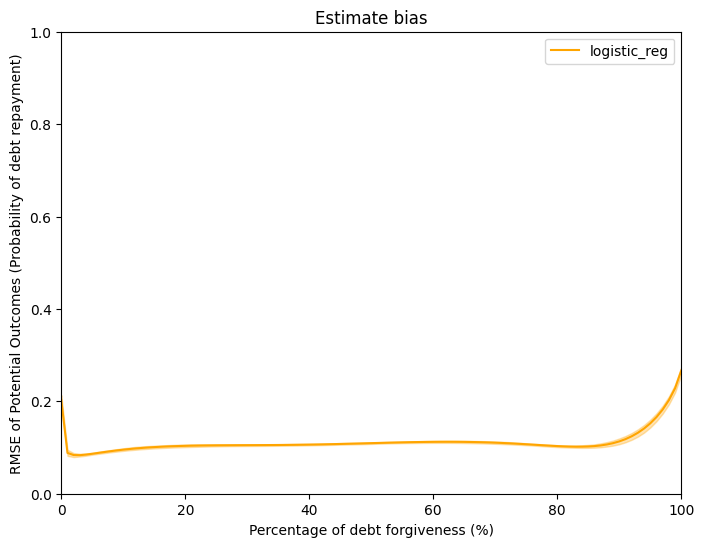

In [25]:
plt.figure(figsize=(8, 6))
for method, results_method in results_pipeline.items():
    plt.plot(
        bin_edges,
        results_method["estimation-error"]["average"],
        label=method,
        color=colors[method],
    )
    plt.fill_between(
        bin_edges,
        results_method["estimation-error"]["lower_bound"],
        results_method["estimation-error"]["upper_bound"],
        alpha=0.3,
        color=colors[method],
    )

plt.xlabel("Percentage of debt forgiveness (%)")
plt.ylabel("RMSE of Potential Outcomes (Probability of debt repayment)")
plt.title("Estimate bias")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

# Comparison

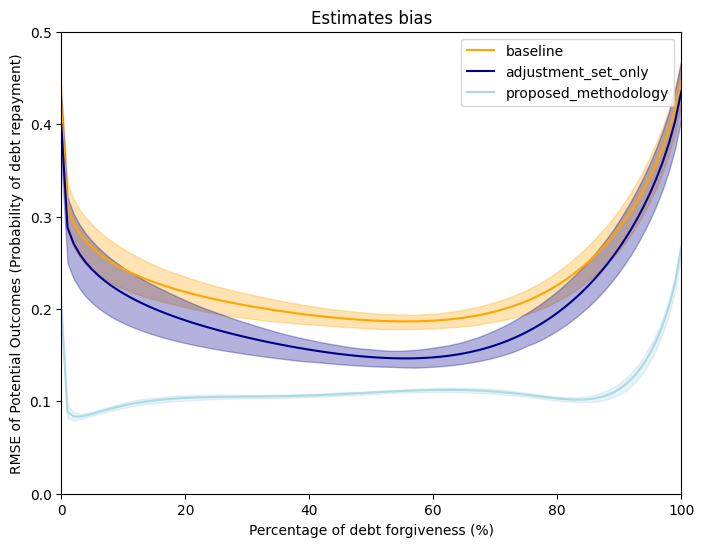

In [26]:
ablation_study = {
    "baseline": results_baseline,
    "adjustment_set_only": results_adjustment_set,
    "proposed_methodology": results_pipeline,
}
colors = {
    "baseline": "orange",
    "adjustment_set_only": "darkblue",
    "proposed_methodology": "lightblue",
}
method=["logi"]

plt.figure(figsize=(8, 6))
for method, results_method in ablation_study.items():
    plt.plot(
        bin_edges,
        results_method[est_methods[0]]["estimation-error"]["average"],
        label=method,
        color=colors[method],
    )
    plt.fill_between(
        bin_edges,
        results_method[est_methods[0]]["estimation-error"]["lower_bound"],
        results_method[est_methods[0]]["estimation-error"]["upper_bound"],
        alpha=0.3,
        color=colors[method],
    )

plt.xlabel("Percentage of debt forgiveness (%)")
plt.ylabel("RMSE of Potential Outcomes (Probability of debt repayment)")
plt.title("Estimates bias")
plt.legend()
plt.ylim(0, 0.5)
plt.xlim(0, 100)
plt.show()

In [27]:
ablation_study = {
    "baseline": results_baseline,
    "adjustment_set_only": results_adjustment_set,
    "proposed_methodology": results_pipeline,
}
colors = {
    "baseline": "orange",
    "adjustment_set_only": "darkblue",
    "proposed_methodology": "lightblue",
}


errors_table = pd.DataFrame(columns=["methodology", "estimation_method", "mean_estimation_bias", "estimation_bias_variance", "[0.05","0.95]"], index=range(len(ablation_study.keys())))

for i, (method, results_ditc_methodology) in enumerate(ablation_study.items()):
    results_method = results_ditc_methodology[est_methods[0]]
    mean_error = results_method["estimation-error"]["average"].mean()
    var_error = results_method["estimation-error"]["average"].var()
    error_lower_bound = results_method["estimation-error"]["lower_bound"].mean()
    error_upper_bound = results_method["estimation-error"]["upper_bound"].mean()
    errors_table.loc[i, :] = [method, est_methods[0], mean_error, var_error, error_lower_bound, error_upper_bound]


errors_table

,methodology,estimation_method,mean_estimation_bias,estimation_bias_variance,[0.05,0.95]
0,baseline,logistic_reg,0.231614,0.00317,0.21572,0.246195
1,adjustment_set_only,logistic_reg,0.200302,0.004006,0.180177,0.220148
2,proposed_methodology,logistic_reg,0.112262,0.00073,0.109136,0.115329
